In [1]:
# путь к папке с моделями
model_path = "./"

In [2]:
# класс и методы необходимые для SVD разложения
from typing import Union

import torch
from torch import Tensor
from torch.nn import Conv2d, Parameter, Module
from torch.nn.common_types import _size_2_t
import os

class DecomposedConv2d(Conv2d):
    """Extends the Conv2d layer by implementing the singular value decomposition of
    the weight matrix.
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        kernel_size: _size_2_t,
        stride: _size_2_t = 1,
        padding: Union[str, _size_2_t] = 0,
        dilation: _size_2_t = 1,
        groups: int = 1,
        bias: bool = True,
        padding_mode: str = "zeros",
        decomposing: bool = True,
        decomposing_mode: str = "channel",
        device=None,
        dtype=None,
    ) -> None:

        super().__init__(
            in_channels,
            out_channels,
            kernel_size,
            stride,
            padding,
            dilation,
            groups,
            bias,
            padding_mode,
            device,
            dtype,
        )

        n, c, w, h = self.weight.size()
        self.decomposing_modes_dict = {
            "channel": (n, c * w * h),
            "spatial": (n * w, c * h),
        }

        if decomposing:
            self.decompose(decomposing_mode)
        else:
            self.U = None
            self.S = None
            self.Vh = None
            self.decomposing = False

    def decompose(self, decomposing_mode: str) -> None:
        """Decompose the weight matrix in singular value decomposition."""

        if decomposing_mode not in self.decomposing_modes_dict.keys():
            raise ValueError(
                "decomposing_mode must be one of {}, but got decomposing_mode='{}'".format(
                    self.decomposing_modes_dict.keys(), decomposing_mode
                )
            )
        W = self.weight.view(self.decomposing_modes_dict[decomposing_mode])
        U, S, Vh = torch.linalg.svd(W, full_matrices=False)

        self.U = Parameter(U)
        self.S = Parameter(S)
        self.Vh = Parameter(Vh)
        self.register_parameter("weight", None)
        self.decomposing = True

    def compose(self) -> None:
        """Compose the weight matrix from singular value decomposition."""

        W = self.U @ torch.diag(self.S) @ self.Vh
        self.weight = Parameter(
            W.view(
                self.out_channels, self.in_channels // self.groups, *self.kernel_size
            )
        )

        self.register_parameter("U", None)
        self.register_parameter("S", None)
        self.register_parameter("Vh", None)
        self.decomposing = False

    def forward(self, input: Tensor) -> Tensor:

        if self.decomposing:
            W = self.U @ torch.diag(self.S) @ self.Vh
            return self._conv_forward(
                input,
                W.view(
                    self.out_channels,
                    self.in_channels // self.groups,
                    *self.kernel_size
                ),
                self.bias,
            )
        else:
            return self._conv_forward(input, self.weight, self.bias)

    def set_U_S_Vh(self, u: Tensor, s: Tensor, vh: Tensor) -> None:
        """Update U, S, Vh matrices."""

        assert self.decomposing, "for setting U, S and Vh, the model must be decomposed"
        self.U = Parameter(u)
        self.S = Parameter(s)
        self.Vh = Parameter(vh)

def energy_threshold_pruning(conv: DecomposedConv2d, energy_threshold: float) -> None:
    """Prune the weight matrices to the energy_threshold (in-place)."""
    assert conv.decomposing, "for pruning, the model must be decomposed"
    S, indices = conv.S.sort()
    U = conv.U[:, indices]
    Vh = conv.Vh[indices, :]
    sum = (S ** 2).sum()
    threshold = energy_threshold * sum
    for i, s in enumerate(S):
        sum -= s ** 2
        if sum < threshold:
            conv.set_U_S_Vh(U[:, i:].clone(), S[i:].clone(), Vh[i:, :].clone())
            break


def decompose_module(model: Module, decomposing_mode: str = "channel") -> None:
    """Replace Conv2d layers with DecomposedConv2d layers in module (in-place)."""
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            decompose_module(module, decomposing_mode=decomposing_mode)

        if isinstance(module, Conv2d):
            new_module = DecomposedConv2d(
                in_channels=module.in_channels,
                out_channels=module.out_channels,
                kernel_size=module.kernel_size,
                stride=module.stride,
                padding=module.padding,
                dilation=module.dilation,
                groups=module.groups,
                bias=(module.bias is not None),
                padding_mode=module.padding_mode,
                decomposing=False,
            )
            new_module.load_state_dict(module.state_dict())
            new_module.decompose(decomposing_mode=decomposing_mode)
            setattr(model, name, new_module)

def prune_model(model, energy_threshold) -> None:
    """Prune the model weights to the energy_threshold."""
    for module in model.modules():
        if isinstance(module, DecomposedConv2d):
            energy_threshold_pruning(conv=module, energy_threshold=energy_threshold)

def number_of_params(model) -> int:
    """Return number of model parameters."""
    return sum(p.numel() for p in model.parameters())

In [3]:
from eXNN.InnerNeuralTopology import homologies, api
from torchvision.datasets import CIFAR10
import torchvision.transforms as TF

In [4]:
from torchmetrics.classification import MulticlassAccuracy
metric = MulticlassAccuracy(num_classes=10)

In [5]:
import torchvision.transforms as TF

tfm = TF.Compose([
    TF.ToTensor(),
    TF.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_ds = CIFAR10(root='./.cache', train=True, download=True, 
                 transform=tfm) #TF.ToTensor()) 
test_ds = CIFAR10(root='./.cache', train=False, download=False, 
                transform=tfm)#TF.ToTensor())

Files already downloaded and verified


In [6]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=512, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=512, shuffle=False)

In [7]:
import torch
from torchvision.models import resnet18

# загрузка обученной модели без разложения
device = torch.device('cpu')
model_name = "ResNet18.sd.pt"
model = resnet18(num_classes=10)
model.load_state_dict(torch.load(model_path + model_name,  map_location=device))
print(f"Number of parameters: {number_of_params(model)}")

model.eval()

Number of parameters: 11181642


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [8]:
batch = next(iter(train_dl))
train_batch = batch[0]

batch = next(iter(test_dl))
test_batch = batch[0]

In [9]:
import matplotlib.pyplot as plt
from IPython.display import display

In [10]:
results_train = api.NetworkHomologies(model, train_batch, layers = ["layer2", "layer4", "fc"],
                                hom_type = "sparse", coefs_type = "2")
results_test = api.NetworkHomologies(model, test_batch, layers = ["layer2", "layer4", "fc"],
                                hom_type = "sparse", coefs_type = "2")

C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
C:\ProgramData\Anaconda3\lib\site-packages\gtda\homology\simplicial.py:910: DataDimensionalityWarning:

Input array X has X.shape[1] == X.shape[2]. This is consistent with a collection of distance/adjacency matrices, but the input is being treated as a collection of vectors in Euclidean space.

C:\ProgramData\Anaconda3\lib\site-packages\gtda\homology\simplicial.py:963: DataDimensionalityWarning:

Input array X has X.shape[1] == X.shape[2]. This is consistent with a collection of distance/adjacency matrices, but the input is being treated as a collection of vectors in Euclidean space.

C:\Pro

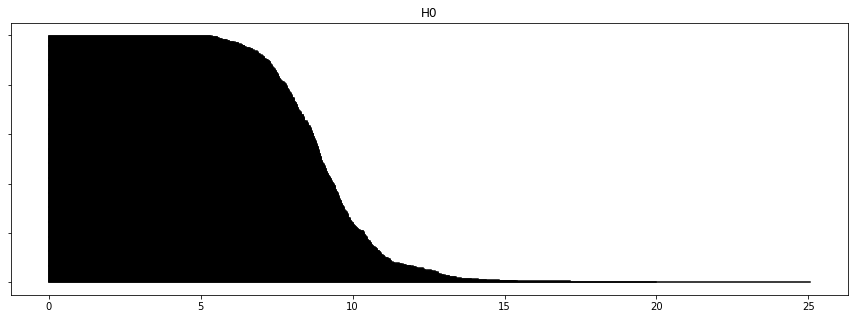

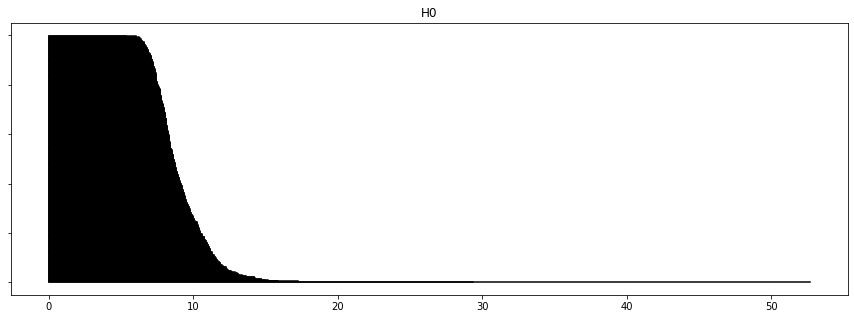

In [11]:
display(results_train["layer4"], results_test["layer4"])

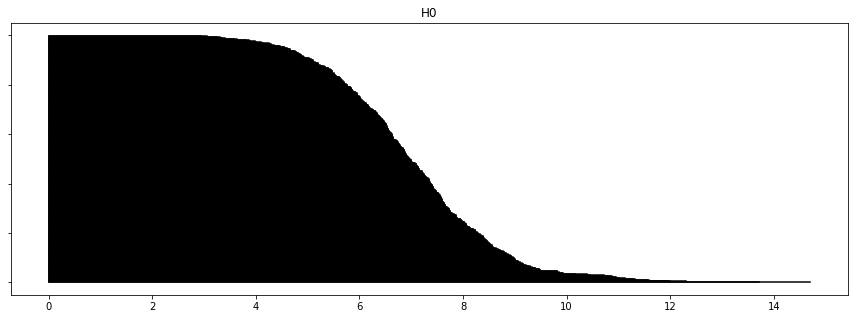

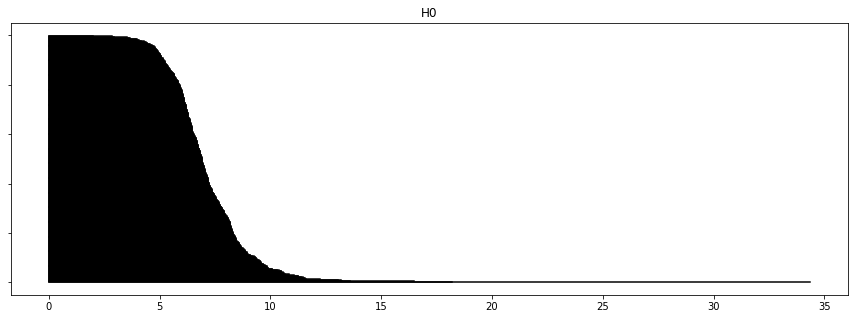

In [12]:
display(results_train["fc"], results_test["fc"])

In [13]:
# загрузка обученной разложенной модели
svd_model_name = 'ResNet18_SVD_channel_O-100.0_H-0.000100.sd.pt'
svd_model = resnet18(num_classes=10)
decompose_module(svd_model, "channel")
svd_model.load_state_dict(torch.load(model_path + svd_model_name,  map_location=device))
print(f"Number of parameters: {number_of_params(svd_model)}")
 
svd_model.eval()

Number of parameters: 12668746


ResNet(
  (conv1): DecomposedConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [14]:
results_train = api.NetworkHomologies(svd_model, train_batch, layers = ["layer2", "layer4", "fc"],
                                hom_type = "sparse", coefs_type = "2")
results_test = api.NetworkHomologies(svd_model, test_batch, layers = ["layer2", "layer4", "fc"],
                                hom_type = "sparse", coefs_type = "2")

C:\ProgramData\Anaconda3\lib\site-packages\gtda\homology\simplicial.py:910: DataDimensionalityWarning:

Input array X has X.shape[1] == X.shape[2]. This is consistent with a collection of distance/adjacency matrices, but the input is being treated as a collection of vectors in Euclidean space.

C:\ProgramData\Anaconda3\lib\site-packages\gtda\homology\simplicial.py:963: DataDimensionalityWarning:

Input array X has X.shape[1] == X.shape[2]. This is consistent with a collection of distance/adjacency matrices, but the input is being treated as a collection of vectors in Euclidean space.

C:\ProgramData\Anaconda3\lib\site-packages\gtda\homology\simplicial.py:910: DataDimensionalityWarning:

Input array X has X.shape[1] == X.shape[2]. This is consistent with a collection of distance/adjacency matrices, but the input is being treated as a collection of vectors in Euclidean space.

C:\ProgramData\Anaconda3\lib\site-packages\gtda\homology\simplicial.py:963: DataDimensionalityWarning:

Input ar

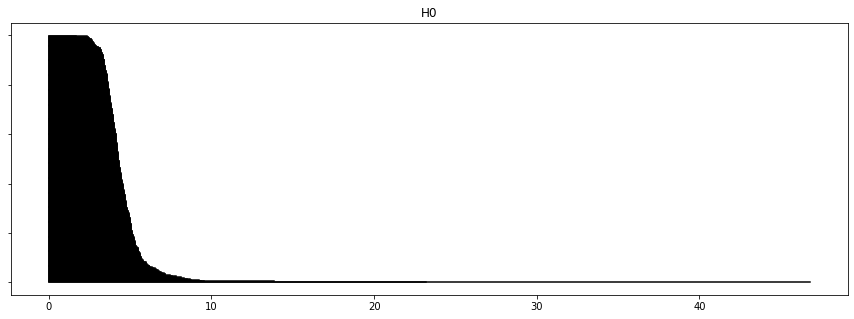

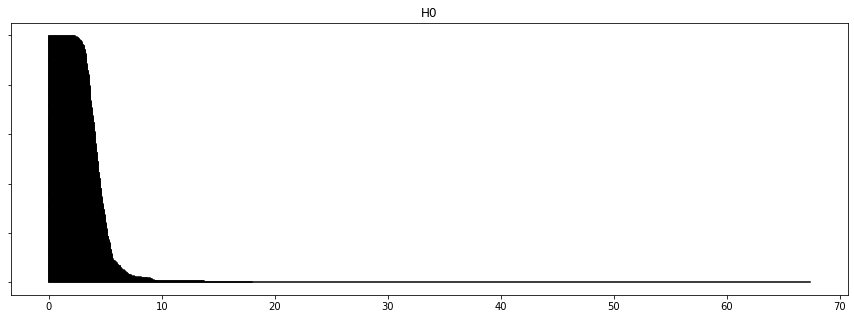

In [15]:
display(results_train["layer4"], results_test["layer4"])

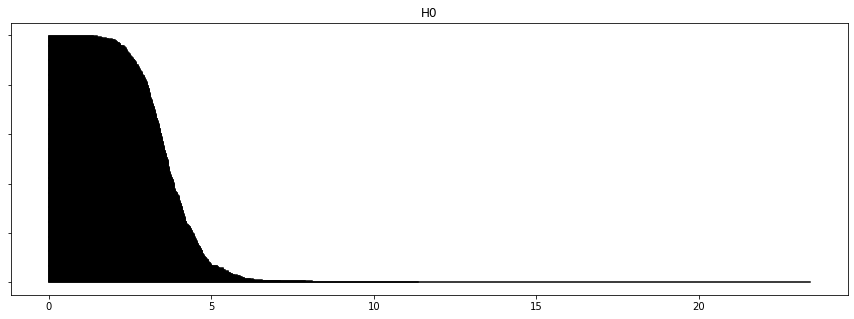

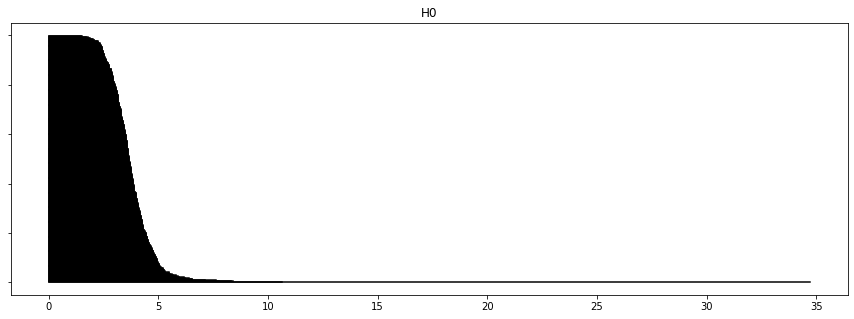

In [16]:
display(results_train["fc"], results_test["fc"])

In [17]:
import copy

#обрезка модели, значения energy_threshold из промежутка (0, 1)
pruned_model = copy.deepcopy(svd_model)
prune_model(model=pruned_model, energy_threshold=0.9)
print(f"Number of parameters: {number_of_params(pruned_model)}")
pruned_model.eval()

Number of parameters: 7206832


ResNet(
  (conv1): DecomposedConv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): DecomposedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=T

In [18]:
results_train = api.NetworkHomologies(pruned_model, train_batch, layers = ["layer2", "layer4", "fc"],
                                hom_type = "sparse", coefs_type = "2")
results_test = api.NetworkHomologies(pruned_model, test_batch, layers = ["layer2", "layer4", "fc"],
                                hom_type = "sparse", coefs_type = "2")

C:\ProgramData\Anaconda3\lib\site-packages\gtda\homology\simplicial.py:910: DataDimensionalityWarning:

Input array X has X.shape[1] == X.shape[2]. This is consistent with a collection of distance/adjacency matrices, but the input is being treated as a collection of vectors in Euclidean space.

C:\ProgramData\Anaconda3\lib\site-packages\gtda\homology\simplicial.py:963: DataDimensionalityWarning:

Input array X has X.shape[1] == X.shape[2]. This is consistent with a collection of distance/adjacency matrices, but the input is being treated as a collection of vectors in Euclidean space.

C:\ProgramData\Anaconda3\lib\site-packages\gtda\homology\simplicial.py:910: DataDimensionalityWarning:

Input array X has X.shape[1] == X.shape[2]. This is consistent with a collection of distance/adjacency matrices, but the input is being treated as a collection of vectors in Euclidean space.

C:\ProgramData\Anaconda3\lib\site-packages\gtda\homology\simplicial.py:963: DataDimensionalityWarning:

Input ar

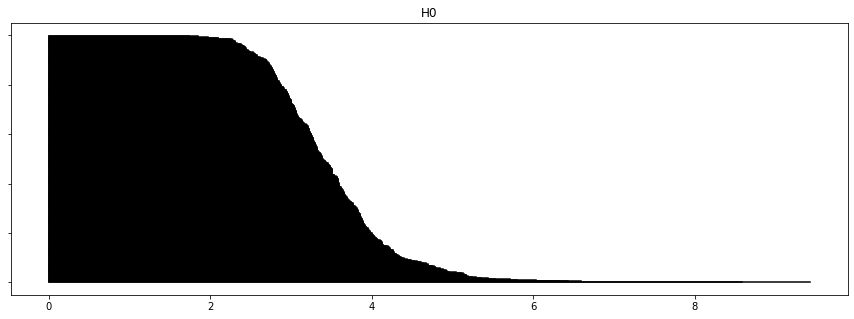

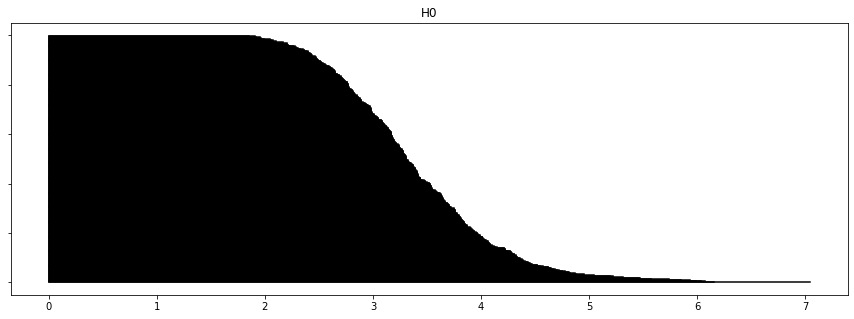

In [19]:
display(results_train["layer4"], results_test["layer4"])

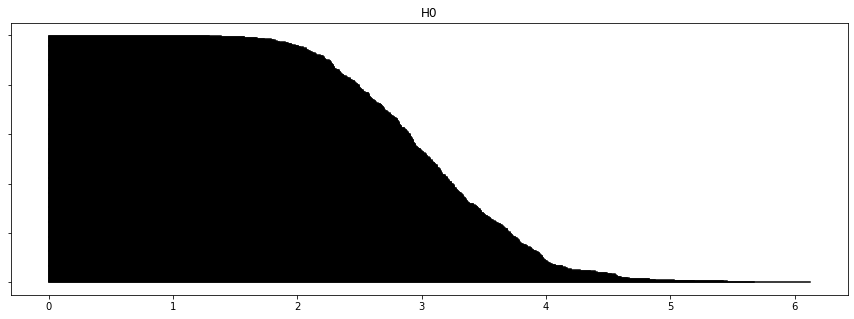

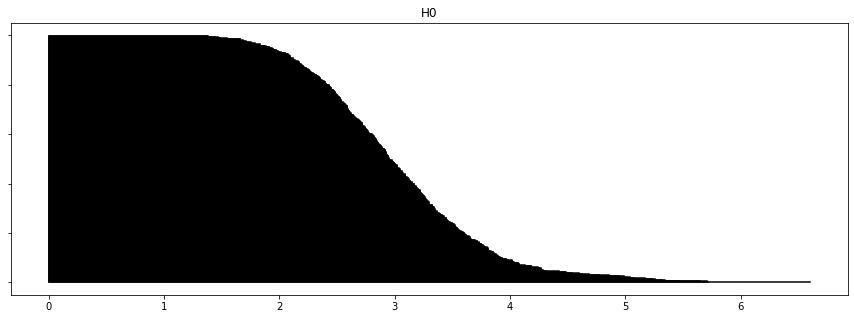

In [20]:
display(results_train["fc"], results_test["fc"])